## Computer Vision - Licence Plate Detection and Recognition 

## Model YOLO V1 

Célestin GABORIAU, Anaëlle MARTY, Alix MEULOT, Timothée POULY

We used AI (especially Copilot auto completion and Chat GPT) to help us coding. Nevertheless, we understand what is done and we debugged a lot of issues. 

### Plan : 

0. Set up the environnment 
1. Import librairies and definie helper functions 
2. Loading data set and preprocessing 
3. Model definition and tuning : yolo v1 
4. Training the model and evaluation 
5. Results 


### 0. Setup

In this notebook, we will implement a system for detecting and recognizing license plates from images using computer vision techniques.

- The requirement are register in the requirements.txt file.
- To install them, run the following command:
  
  ```bash
  pip install -r requirements.txt
  ```


### 1. Importing Libraries and Defining Helper Functions

In [1]:
import os
import cv2
import yaml
import shutil
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset
from PIL import Image
import torch
import sys
# print(torch.cuda.is_available())

from ultralytics import YOLO
sys.path.append("../src")

from utils import pair_split, display_image_with_bboxes, plot_yolo_sample

Check what processor is available on your computer : 

CPU : If you have only a CPU, you should use the dataset_small1. The model training and results are going to run a long time (around 1 hour for one model). 

GPU : You can use both of the dataset to run the models. 

In [ ]:
if torch.cuda.is_available():
    print(f"GPU détecté !")
    print(f"Nom du GPU : {torch.cuda.get_device_name(0)}")
    print(f"Mémoire disponible : {torch.cuda.get_memory_info(0).total / 1e9:.2f} GB")
else:
    print("Aucun GPU détecté (ou pilotes CUDA non installés).")

❌ Aucun GPU détecté (ou pilotes CUDA non installés).


Personal note : To define the model and run them, we used our own computer. We train the model with the dataset_small1. 

### 2. Loading Dataset and Preprocessing

#### Optional - download a reduced "dataset_small1 " :

Reduce the dataset - using CPU device: 

In [ ]:
# --- CONFIGURATION DES CHEMINS ---
# On définit la racine du projet (un niveau au-dessus du dossier 'notebooks')
# Cela permet d'accéder à /data et /src facilement
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
PATH_SOURCE = os.path.join(PROJECT_ROOT, "data") 
PATH_SMALL = os.path.join(PROJECT_ROOT, "dataset_small1")

print(f"Racine du projet : {PROJECT_ROOT}")
print(f"Source des données : {PATH_SOURCE}")

# Vérification immédiate
if not os.path.exists(PATH_SOURCE):
    print("Erreur : Le dossier 'data' est introuvable à la racine. Vérifie l'arborescence.")
else:
    print("Dossier 'data' détecté.")

🏠 Racine du projet : c:\Users\timpo\OneDrive\Bureau\ICVIS_project
📂 Source des données : c:\Users\timpo\OneDrive\Bureau\ICVIS_project\data
❌ Erreur : Le dossier 'data' est introuvable à la racine. Vérifie l'arborescence.


## DO NOT LAUNCH THE FOLLOWING CELL IF YOU ALREADY HAVE dataset_small1 !

In [ ]:
#Creation du dataset_small1: 
import random
def setup_local_dataset(source, target, n_train=800, n_val=150, n_test=50):
    if os.path.exists(target):
        shutil.rmtree(target)
    
    splits = {'train': n_train, 'val': n_val, 'test': n_test}
    
    for split, count in splits.items():
        img_out = os.path.join(target, 'images', split)
        lab_out = os.path.join(target, 'labels', split)
        os.makedirs(img_out, exist_ok=True)
        os.makedirs(lab_out, exist_ok=True)
        
        # On cherche dans /data/images/train, etc.
        img_src_dir = os.path.join(source, 'images', split)
        lab_src_dir = os.path.join(source, 'labels', split)
        
        if not os.path.exists(img_src_dir):
            print(f"Dossier {split} introuvable dans {source}")
            continue

        all_imgs = [f for f in os.listdir(img_src_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        valid_imgs = [i for i in all_imgs if os.path.exists(os.path.join(lab_src_dir, os.path.splitext(i)[0] + ".txt"))]
        
        selected = random.sample(valid_imgs, min(count, len(valid_imgs)))
        
        for img_name in selected:
            shutil.copy(os.path.join(img_src_dir, img_name), os.path.join(img_out, img_name))
            shutil.copy(os.path.join(lab_src_dir, os.path.splitext(img_name)[0] + ".txt"), 
                        os.path.join(lab_out, os.path.splitext(img_name)[0] + ".txt"))
    
    print(f"Dataset réduit créé : {target}")

setup_local_dataset(PATH_SOURCE, PATH_SMALL)

✅ Dataset réduit créé : c:\Users\anael\Desktop\Projet 3A\ICVIS_project\dataset_small1


#### 2.0 Define path variables

In [3]:
# Grand dataset 
#image_dir = "../data/images"
#label_dir = "../data/labels"

#petit dataset 
image_dir = "../dataset_small1/images"
label_dir = "../dataset_small1/labels"

#### 2.1 Define a function to pair images and labels

In [4]:
train_pairs = pair_split(image_dir+"/train", label_dir+"/train")
val_pairs   = pair_split(image_dir+"/val", label_dir+"/val")
test_pairs  = pair_split(image_dir+"/test", label_dir+"/test")

#### 2.2 Convert into normalized dataset

In [5]:
import os
from PIL import Image

def process_pairs_to_normalized_dataset(pairs):
    dataset_list = []

    for img_path, label_path in pairs:
        # Charger l'image
        try:
            img_pil = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            continue

        bboxes = []
        class_ids = []

        # Lire le fichier label YOLO (format: class xc yc w h)
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if not parts: continue
                    
                    c, xc, yc, w, h = map(float, parts)
                    
                    # On garde les valeurs telles quelles (normalisées)
                    bboxes.append([xc, yc, w, h])
                    class_ids.append(int(c))
        
        dataset_list.append((img_pil, bboxes, class_ids))

    return dataset_list


In [6]:
train_dataset = process_pairs_to_normalized_dataset(train_pairs)
val_dataset   = process_pairs_to_normalized_dataset(val_pairs)
test_dataset  = process_pairs_to_normalized_dataset(test_pairs)

#### 2.3 Transorm into PyTorch Dataset (YOLO format)

In [7]:
class YoloDataset(Dataset):
    def __init__(self, pairs, transform, S=13):
        self.pairs = pairs              # (img_path, label_path)
        self.transform = transform
        self.S = S

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, label_path = self.pairs[idx]

        # 1. Image
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # 2. Label matrix
        label_matrix = torch.zeros((self.S, self.S, 5))


        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    c, xc, yc, w, h = map(float, line.split())

                    i = min(int(yc * self.S), self.S - 1)
                    j = min(int(xc * self.S), self.S - 1)


                    label_matrix[i, j, 4] = 1.0
                    label_matrix[i, j, 0:4] = torch.tensor([
                        xc * self.S - j,
                        yc * self.S - i,
                        w, h
                    ])
                    

        return img, label_matrix


In [ ]:
import torchvision.transforms as transforms


IMAGE_SIZE = 416 

my_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
    transforms.ToTensor(),                       
])


train_ds = YoloDataset(train_pairs, transform=my_transforms, S=13)
val_ds   = YoloDataset(val_pairs,   transform=my_transforms, S=13)
test_ds  = YoloDataset(test_pairs,  transform=my_transforms, S=13)


#### 2.4 Visualizing an example from the dataset

Image tensor shape: torch.Size([3, 416, 416])
Label matrix shape: torch.Size([13, 13, 5])


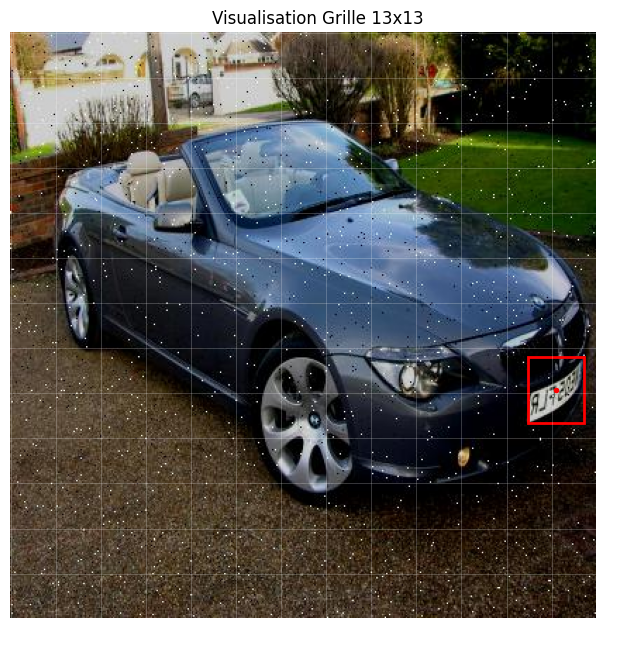

In [9]:
img, label = train_ds[10] 
print("Image tensor shape:", img.shape)
print("Label matrix shape:", label.shape)
plot_yolo_sample(img, label, S=13)

In [ ]:
from torch.utils.data import DataLoader 
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

### 3. Model Definition

#### 3.1 Yolo v1 

In [ ]:
import torch
import torch.nn as nn

class YOLOv1(nn.Module):
    def __init__(self, S=13, C=1):
        super().__init__()
        self.S = S
        self.C = C
        self.out_channels = 5 + C  # x,y,w,h,obj + classes

        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 192, 3, 1, 1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(192, 128, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),

            *[nn.Sequential(
                nn.Conv2d(512, 256, 1),
                nn.LeakyReLU(0.1),
                nn.Conv2d(256, 512, 3, 1, 1),
                nn.LeakyReLU(0.1)
            ) for _ in range(4)],

            nn.Conv2d(512, 1024, 3, 1, 1),
            nn.LeakyReLU(0.1),

           
            nn.MaxPool2d(2, 2),  # 26×26 → 13×13
        )

        self.pred_head = nn.Conv2d(1024, self.out_channels, 1)

    def forward(self, x):
        x = self.features(x)
        x = self.pred_head(x)

        #sécurité dimensionnelle
        assert x.shape[2] == self.S and x.shape[3] == self.S, \
            f"Output grid {x.shape[2:]} ≠ S={self.S}"

        x = x.permute(0, 2, 3, 1)

        #contraintes YOLO
        x[..., 0:2] = torch.sigmoid(x[..., 0:2])  # x,y
        x[..., 2:4] = torch.sigmoid(x[..., 2:4])  # w,h
        x[..., 4]   = torch.sigmoid(x[..., 4])    # objectness

        return x


In [12]:
test = YOLOv1(S=7, C=1)
print(test)

YOLOv1(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.1)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.1)
    (10): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (11): LeakyReLU(negative_slope=0.1)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.1)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Sequential(
      (0): Conv2d(512, 256,

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = YOLOv1(S=13, C=1).to(device)

bbox_loss_fn = nn.MSELoss() 
cls_loss_fn = nn.CrossEntropyLoss()  

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []


### 4. Training and Evaluation

In [ ]:
def yolo_loss(pred, target, lambda_coord=5, lambda_noobj=0.5):
    obj_mask   = target[..., 4] == 1
    noobj_mask = target[..., 4] == 0

    # --- COORD LOSS ---
    if obj_mask.sum() > 0:
        loss_xy = ((pred[...,0:2] - target[...,0:2])**2)[obj_mask].mean()

        loss_wh = ((torch.sqrt(pred[...,2:4] + 1e-6) -
                    torch.sqrt(target[...,2:4] + 1e-6))**2)[obj_mask].mean()
    else:
        loss_xy = loss_wh = torch.tensor(0.0, device=pred.device)

    # --- OBJECTNESS LOSS ---
    loss_obj = F.binary_cross_entropy(pred[...,4][obj_mask],
                                      target[...,4][obj_mask]) \
               if obj_mask.sum() > 0 else torch.tensor(0.0, device=pred.device)

    loss_noobj = F.binary_cross_entropy(pred[...,4][noobj_mask],
                                        target[...,4][noobj_mask]) \
                 if noobj_mask.sum() > 0 else torch.tensor(0.0, device=pred.device)

    return lambda_coord*(loss_xy + loss_wh) + loss_obj + lambda_noobj*loss_noobj


In [ ]:
import torch.nn.functional as F

img, label = train_ds[0]
img = img.unsqueeze(0).to(device)
label = label.unsqueeze(0).to(device)

model = YOLOv1(S=13, C=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for step in range(500):
    pred = model(img)
    loss = yolo_loss(pred, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step} | Loss {loss.item():.6f}")


Hyperparameter tuning, very long cell (do not run, i have them because i did it on kaggle with a gpu boost)

In [ ]:
import itertools
import random
'''
# --- HYPERPARAMETERS A TESTER ---
learning_rates = [1e-3, 5e-4, 1e-4]
batch_sizes = [16, 32, 64]
lambda_coords = [5, 3]
lambda_noobjs = [0.5, 0.3]
num_epochs = 6  # epochs max pour le test rapide

# --- COMBINAISONS ---
param_combinations = list(itertools.product(learning_rates, batch_sizes, lambda_coords, lambda_noobjs))

# --- ÉCHANTILLON DE 10 COMBINAISONS ---
random.seed(42)  # pour reproductibilité
param_combinations = random.sample(param_combinations, 10)

# --- STOCKAGE DES RESULTATS ---
results = []

for lr, bs, lc, lno in param_combinations:
    print(f"\n=== Test: lr={lr}, batch_size={bs}, lambda_coord={lc}, lambda_noobj={lno} ===")
    
    # Dataloaders
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=bs, shuffle=False)
    
    # Nouveau modèle
    model = YOLOv1(S=13, C=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Training loop minimal
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        # Train
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(imgs)
            loss = yolo_loss(preds, labels, lambda_coord=lc, lambda_noobj=lno)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        
        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for imgs_v, labels_v in val_loader:
                imgs_v, labels_v = imgs_v.to(device), labels_v.to(device)
                preds_v = model(imgs_v)
                v_loss = yolo_loss(preds_v, labels_v, lambda_coord=lc, lambda_noobj=lno)
                total_val_loss += v_loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
        
        # Affichage par epoch pour suivre la progression
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.3f} | Val Loss: {avg_val_loss:.3f}")

    results.append({
        "lr": lr, "batch_size": bs, "lambda_coord": lc, "lambda_noobj": lno,
        "best_val_loss": best_val_loss
    })
    print(f"Best Val Loss for this combo: {best_val_loss:.3f}")

# --- TRI ET AFFICHAGE ---
results = sorted(results, key=lambda x: x["best_val_loss"])
best_params = results[0]
print("\n=== Top Hyperparameter Set ===")
print(best_params)
'''

In [17]:
# After running the hyperparameter search, we found:
best_params = {'lr': 0.0005, 'batch_size': 16, 'lambda_coord': 3, 'lambda_noobj': 0.5, 'best_val_loss': 0.975434523820877}

The following cell is very long to run, you don't need to launch it if you already have a model ready in the models folder : 

In [ ]:
# --- Boucle d'entraînement avec EarlyStopping et best_params ---
model = YOLOv1(S=13, C=1).to(device)

# --- Paramètres optimisés ---
lr = best_params["lr"]
batch_size = best_params["batch_size"]
lambda_coord = best_params["lambda_coord"]
lambda_noobj = best_params["lambda_noobj"]

# --- Dataloaders ---
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss_history = []
val_loss_history = []

# --- EarlyStopping ---
patience = 5
best_val_loss = float('inf')
counter = 0

num_epochs = 30
for epoch in range(num_epochs):

    # ============================
    # 1. PHASE ENTRAÎNEMENT
    # ============================
    model.train()
    total_train_loss = 0
    num_batches = 0

    for imgs, labels in train_loader:
        imgs   = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        preds = model(imgs)

        loss = yolo_loss(
            preds, labels,
            lambda_coord=lambda_coord,
            lambda_noobj=lambda_noobj
        )

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        num_batches += 1

    avg_train_loss = total_train_loss / num_batches
    train_loss_history.append(avg_train_loss)

    # ============================
    # 2. PHASE VALIDATION
    # ============================
    model.eval()
    total_val_loss = 0
    num_val_batches = 0

    with torch.no_grad():
        for imgs_v, labels_v in val_loader:
            imgs_v   = imgs_v.to(device)
            labels_v = labels_v.to(device)

            preds_v = model(imgs_v)

            v_loss = yolo_loss(
                preds_v, labels_v,
                lambda_coord=lambda_coord,
                lambda_noobj=lambda_noobj
            )

            total_val_loss += v_loss.item()
            num_val_batches += 1

    avg_val_loss = total_val_loss / num_val_batches
    val_loss_history.append(avg_val_loss)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f}"
    )

    # ============================
    # 3. EARLY STOPPING
    # ============================
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        os.makedirs("models", exist_ok=True)
        torch.save(model.state_dict(), "models/best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"EarlyStopping déclenché à l’epoch {epoch+1}")
            break


torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([32, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([22, 13, 13, 6])
Epoch 1: Loss 109.244/98.233 | Acc 40.9%/100.0%
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([32, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([64, 13, 13, 6])
torch.Size([22, 13, 13, 6])
Epoch 2: Loss 66.899/92.655 | Acc 100.0%/100.0%
torch.Si

<All keys matched successfully>

If you already have trained the model, you can run this to gain time :

In [19]:
# Chargement du meilleur modèle

model.load_state_dict(torch.load("models/best_model.pth", map_location=torch.device('cpu')))


<All keys matched successfully>

### 5. Reading Parts

#### Evolution of Loss and accuracy during the epochs: 

The following cell cannot run because we used the pretrained model generated by the kaggle notebook, see kaggle notebook

NameError: name 'val_loss_history' is not defined

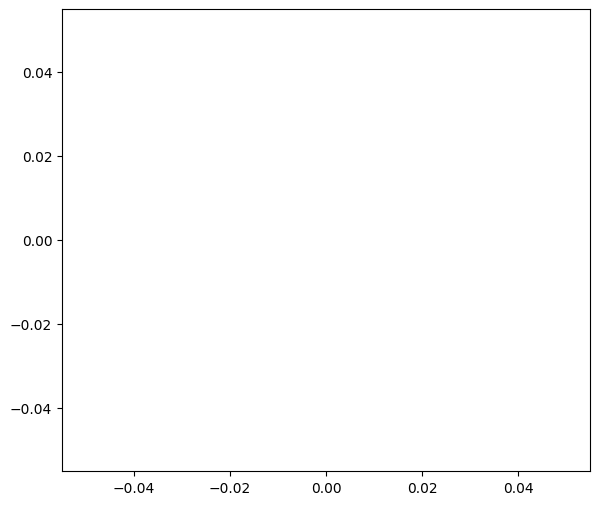

In [ ]:
import matplotlib.pyplot as plt

# Configuration du style
plt.figure(figsize=(15, 6))

# --- GRAPHIQUE 1 : LOSS (Erreur) ---
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, 
         label='Training $Loss$', color='#1f77b4', marker='o', linewidth=2)
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, 
         label='Validation $Loss$', color='#d62728', marker='s', linestyle='--', linewidth=2)

plt.title("Évolution de la Perte ($YOLO$ $Loss$)", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("$Loss$", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle=':', alpha=0.7)





plt.title("Précision de Détection des Plaques", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("$Accuracy$ (%)", fontsize=12)
plt.ylim(0, 105) # Pour bien voir la progression jusqu'à 100%
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()

# Sauvegarde pour tes slides
plt.savefig("courbes_apprentissage_yolo.png", dpi=300)
plt.show()

#### Confusion matrix : 

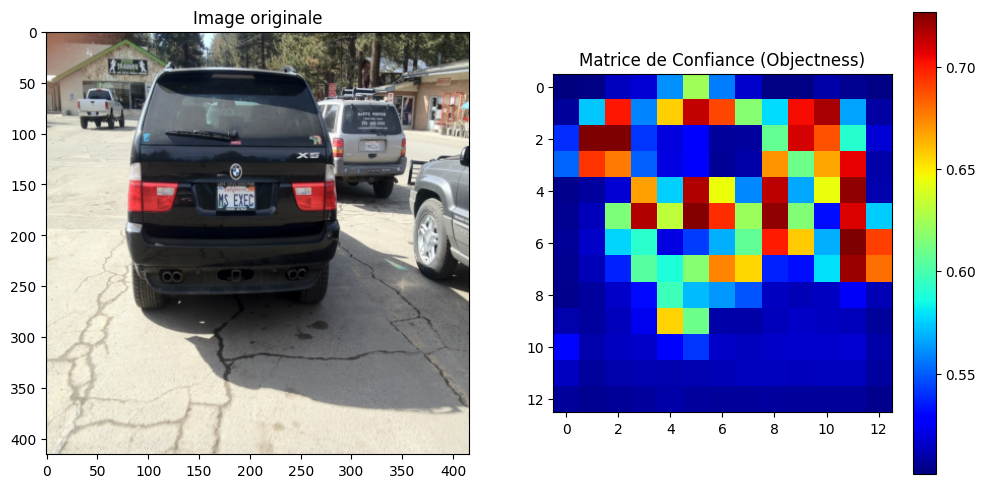

In [21]:
# Visualisation de la matrice de confiance (objectness) pour une image du dataset de validation

def plot_confidence_heatmap(model, dataset, idx=0):
    model.eval()
    img, target = dataset[idx]
    
    # Prédiction (on ajoute une dimension batch et on envoie sur le bon device)
    with torch.no_grad():
        prediction = model(img.unsqueeze(0).to(device))
    
    # On récupère le score d'objectness (canal 4) et on applique sigmoid
    # La forme est (1, 13, 13, 6) -> on veut (13, 13)
    conf_map = torch.sigmoid(prediction[0, ..., 4]).cpu().numpy()

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Image originale
    ax[0].imshow(img.permute(1, 2, 0))
    ax[0].set_title("Image originale")
    
    # Heatmap
    im = ax[1].imshow(conf_map, cmap='jet')
    ax[1].set_title("Matrice de Confiance (Objectness)")
    plt.colorbar(im, ax=ax[1])
    plt.show()

# Utilisation
plot_confidence_heatmap(model, val_ds, idx=1)

To evaluate our YOLOv1 model, we use a two-step approach:


> Qualitative Evaluation: We use show_results to visualize the predictions. This helps identify common failure cases (e.g., partial occlusions or lighting conditions).

> Post-Processing: The apply_nms function is critical here to ensure we only evaluate the most confident prediction per object.

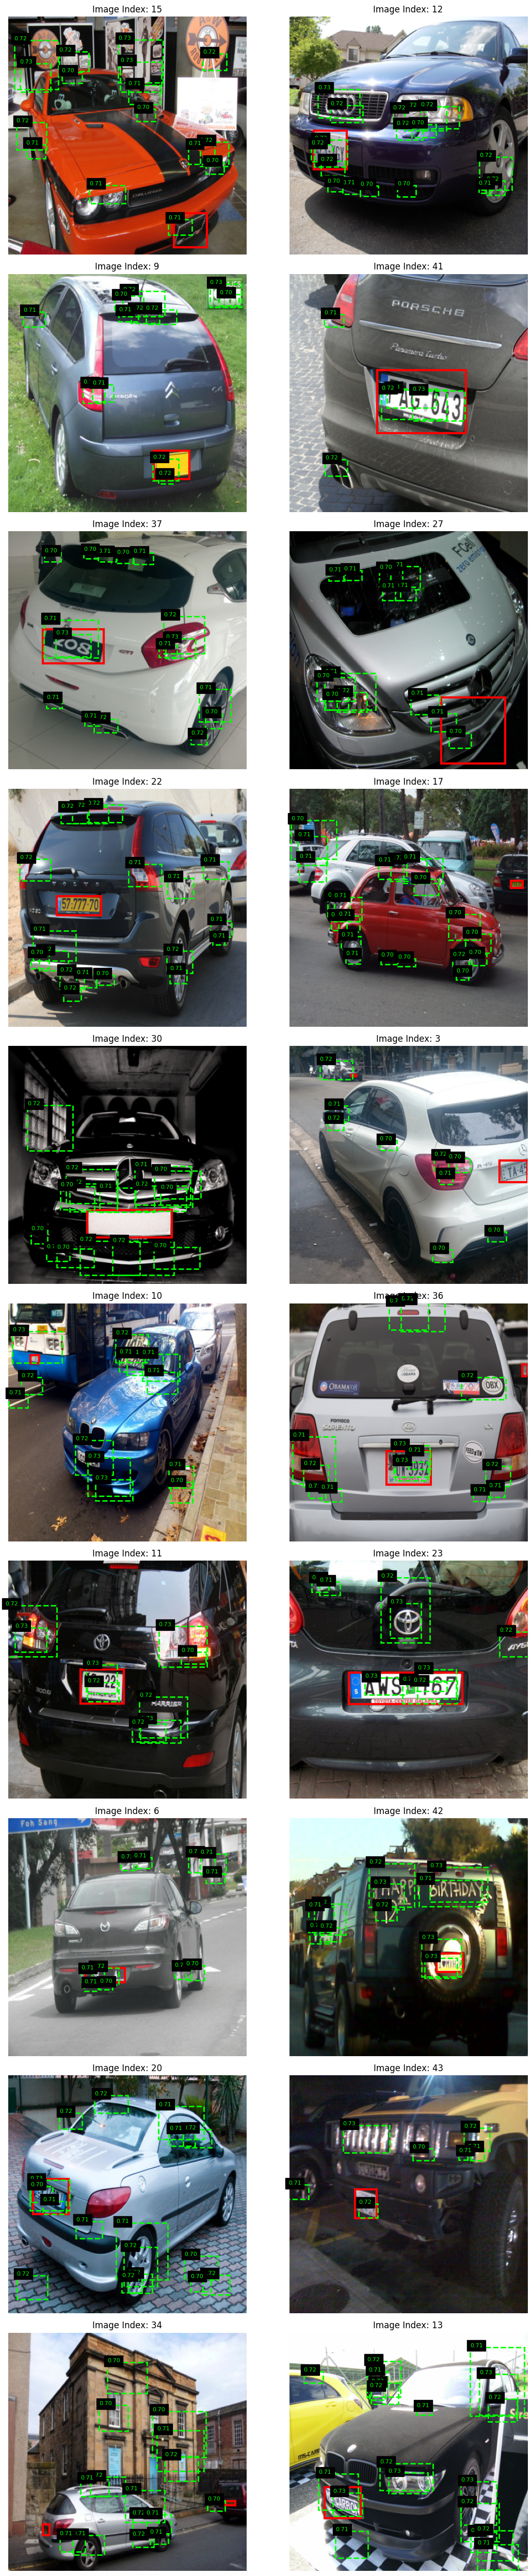

In [23]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# 1. PARAMETRES (A vérifier selon ton code)
S_GRID = 13
IMG_SIZE = 416
id_to_name = {0: "Plaque"} # Ajuste si ton label commence à 1

# ==========================================
# 2. FONCTIONS DE CALCUL (IoU & NMS)
# ==========================================
def iou(box1, box2):
    # box format: [x_center, y_center, w, h] (normalized 0-1)
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    x1a, y1a = x1 - w1/2, y1 - h1/2
    x1b, y1b = x1 + w1/2, y1 + h1/2
    x2a, y2a = x2 - w2/2, y2 - h2/2
    x2b, y2b = x2 + w2/2, y2 + h2/2

    xi1, yi1 = max(x1a, x2a), max(y1a, y2a)
    xi2, yi2 = min(x1b, x2b), min(y1b, y2b)
    
    inter = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    union = (w1 * h1) + (w2 * h2) - inter
    return inter / (union + 1e-6)

def apply_nms(boxes, scores, iou_thresh=0.45):
    if len(boxes) == 0: return []
    
    # Tri par score de confiance
    idxs = scores.argsort(descending=True)
    keep = []
    
    while len(idxs) > 0:
        curr = idxs[0].item()
        keep.append(curr)
        if len(idxs) == 1: break
        
        # On ne garde que les boites dont l'IoU avec la boite actuelle est faible
        rem_idxs = idxs[1:]
        ious = torch.tensor([iou(boxes[curr], boxes[i.item()]) for i in rem_idxs])
        mask = ious < iou_thresh
        idxs = rem_idxs[mask]
        
    return keep

# ==========================================
# 3. DECODAGE DE LA GRILLE (Le secret du placement)
# ==========================================
def decode_yolo_grid(tensor, S=13, is_target=False):
    boxes, scores, classes = [], [], []
    
    for i in range(S):
        for j in range(S):
            cell = tensor[i, j]

            conf = cell[4].item() if is_target else torch.sigmoid(cell[4]).item()
            if conf < 0.1:
                continue

            px, py, pw, ph = cell[0:4]
            gx = (j + px) / S
            gy = (i + py) / S

            boxes.append([gx.item(), gy.item(), pw.item(), ph.item()])
            scores.append(conf)

            if is_target:
                classes.append(0)  # target = classe unique
            else:
                classes.append(int(cell[5].item()))  # prediction

    return torch.tensor(boxes), torch.tensor(scores), torch.tensor(classes)



# ==========================================
# 4. FONCTION DE VISUALISATION FINALE
# ==========================================
def show_results(dataset, model, num_images=4, conf_thresh=0.7):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    
    rows = (num_images + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(12, rows*5))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        img, target = dataset[idx]
        
        # --- TRAITEMENT VÉRITÉ (ROUGE) ---
        gt_boxes, gt_scores, gt_classes = decode_yolo_grid(target, S=S_GRID, is_target=True)

        # --- TRAITEMENT PRÉDICTION (VERT) ---
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device))[0].cpu()
        p_boxes, p_scores, p_classes = decode_yolo_grid(pred, S=S_GRID, is_target=False)
        
        # Application du NMS sur les prédictions
        if len(p_boxes) > 0:
            mask = p_scores > conf_thresh
            p_boxes, p_scores, p_classes = p_boxes[mask], p_scores[mask], p_classes[mask]
            keep = apply_nms(p_boxes, p_scores)
            p_boxes, p_scores, p_classes = p_boxes[keep], p_scores[keep], p_classes[keep]

        # --- DESSIN ---
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.set_title(f"Image Index: {idx}")
        
        # Dessin GT (Rouge)
        for box in gt_boxes:
            x, y, w, h = box
            # x, y est le centre -> conversion corner pour Rectangle()
            ax.add_patch(patches.Rectangle(((x-w/2)*IMG_SIZE, (y-h/2)*IMG_SIZE), 
                                           w*IMG_SIZE, h*IMG_SIZE, 
                                           edgecolor='red', linewidth=3, fill=False))
        
        # Dessin Pred (Vert Lime)
        for box, sc in zip(p_boxes, p_scores):
            x, y, w, h = box
            ax.add_patch(patches.Rectangle(((x-w/2)*IMG_SIZE, (y-h/2)*IMG_SIZE), 
                                           w*IMG_SIZE, h*IMG_SIZE, 
                                           edgecolor='lime', linewidth=2, fill=False, linestyle='--'))
            ax.text((x-w/2)*IMG_SIZE, (y-h/2)*IMG_SIZE, f"{sc:.2f}", color='lime', fontsize=8, backgroundcolor='black')

        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def show_gt_only(dataset, num_images=4):
    indices = random.sample(range(len(dataset)), num_images)
    
    rows = (num_images + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(12, rows*5))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        img, target = dataset[idx]
        
        # --- TRAITEMENT VÉRITÉ (ROUGE) ---
        gt_boxes, gt_scores, gt_classes = decode_yolo_grid(target, S=S_GRID, is_target=True)

        # --- DESSIN ---
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.set_title(f"Image Index: {idx}")
        
        # Dessin GT (Rouge)
        for box in gt_boxes:
            x, y, w, h = box
            # x, y est le centre -> conversion corner pour Rectangle()
            ax.add_patch(patches.Rectangle(((x-w/2)*IMG_SIZE, (y-h/2)*IMG_SIZE), 
                                           w*IMG_SIZE, h*IMG_SIZE, 
                                           edgecolor='red', linewidth=3, fill=False))
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# LANCEMENT
show_results(test_ds, model, num_images=20, conf_thresh=0.7)

### Video tracking (frame per frame analysis)

In [72]:
# separate the frame of a video into images and save them in a folder

def video_to_frames(video_path, output_folder, frame_rate=1):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    count = 0
    saved_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if count % frame_rate == 0:
            frame_filename = os.path.join(output_folder, f"frame_{saved_count:05d}.jpg")
            cv2.imwrite(frame_filename, frame)
            saved_count += 1

        count += 1

    cap.release()
    print(f"Extraction terminée. {saved_count} images sauvegardées dans '{output_folder}'.")

In [73]:
# apply the function on a sample video Timothée took with his friend Tristan

video_path = "../video/voiture_tristan.mp4"
output_folder = "../video/video_frames"

video_to_frames(video_path, output_folder)  

Extraction terminée. 151 images sauvegardées dans '../video/video_frames'.


In [74]:
# crop the images to 416x416 size and centered crop and save them in another folder. We also save the top and bottom, left and right cropped parts in another folder

def crop_images(input_folder, output_folder_center, output_folder_edges, crop_size=416):
    if not os.path.exists(output_folder_center):
        os.makedirs(output_folder_center)
    if not os.path.exists(output_folder_edges):
        os.makedirs(output_folder_edges)

    for img_name in os.listdir(input_folder):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(input_folder, img_name)
            img = Image.open(img_path).convert("RGB")
            width, height = img.size

            # Center crop
            left = (width - crop_size) / 2
            top = (height - crop_size) / 2
            right = (width + crop_size) / 2
            bottom = (height + crop_size) / 2
            center_crop = img.crop((left, top, right, bottom))
            center_crop.save(os.path.join(output_folder_center, img_name))

            # Edge crops
            top_crop = img.crop((0, 0, width, crop_size))
            bottom_crop = img.crop((0, height - crop_size, width, height))
            left_crop = img.crop((0, 0, crop_size, height))
            right_crop = img.crop((width - crop_size, 0, width, height))

            top_crop.save(os.path.join(output_folder_edges, f"top_{img_name}"))
            bottom_crop.save(os.path.join(output_folder_edges, f"bottom_{img_name}"))
            left_crop.save(os.path.join(output_folder_edges, f"left_{img_name}"))
            right_crop.save(os.path.join(output_folder_edges, f"right_{img_name}"))

    print(f"Images saved in '{output_folder_center}' and '{output_folder_edges}'.")


In [75]:
input_folder = "../video/video_frames"
output_folder = "../video/video_frames_cropped"
crop_images(input_folder, output_folder + "/center", output_folder + "/edges", crop_size=416)

Images saved in '../video/video_frames_cropped/center' and '../video/video_frames_cropped/edges'.


In [76]:
import torch

def decode_yolo_pred(tensor, S=13, conf_thresh=0.4):
    """
    Décodage des prédictions YOLOv1 pour une image.
    
    Args:
        tensor: (S, S, 5+C) tensor de sortie du modèle
        S: taille de la grille
        conf_thresh: seuil minimal de confiance pour afficher une bbox
        
    Returns:
        boxes: list de [x_center, y_center, w, h] normalisé [0-1]
        scores: list des scores de confiance
        classes: list des indices de classes
    """
    boxes, scores, classes = [], [], []
    C = tensor.shape[-1] - 5

    for i in range(S):
        for j in range(S):
            cell = tensor[i, j]
            conf = torch.sigmoid(cell[4])  # objectness
            if conf < conf_thresh:
                continue

            px, py, pw, ph = cell[0:4]

            # Convertir x,y en coordonnées globales [0,1]
            gx = (j + torch.sigmoid(px)) / S
            gy = (i + torch.sigmoid(py)) / S
            w  = pw.clamp(0,1)
            h  = ph.clamp(0,1)

            cls_id = torch.argmax(cell[5:])
            boxes.append([gx.item(), gy.item(), w.item(), h.item()])
            scores.append(conf.item())
            classes.append(cls_id.item())

    return boxes, scores, classes


In [77]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_pred_image(model, img_path, transform, S=13, IMG_SIZE=416, conf_thresh=0.4):
    """
    Applique le modèle sur une image et affiche les bboxes.
    
    Args:
        model: ton modèle YOLOv1
        img_path: chemin vers l'image
        transform: transformations (resize + ToTensor)
        S: taille de la grille
        IMG_SIZE: taille de l'image après transformation
        conf_thresh: seuil de confiance pour afficher une bbox
    """
    # Charger image
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(next(model.parameters()).device)

    # Prediction
    model.eval()
    with torch.no_grad():
        pred = model(img_tensor)[0].cpu()

    boxes, scores, classes = decode_yolo_pred(pred, S=S, conf_thresh=conf_thresh)

    # Affichage
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img)

    for box, score, cls in zip(boxes, scores, classes):
        x, y, w, h = box
        x0 = (x - w/2) * IMG_SIZE
        y0 = (y - h/2) * IMG_SIZE
        w0 = w * IMG_SIZE
        h0 = h * IMG_SIZE

        rect = patches.Rectangle((x0, y0), w0, h0, linewidth=2, edgecolor='lime', facecolor='none', linestyle='--')
        ax.add_patch(rect)
        ax.text(x0, y0, f"{score:.2f}", color='lime', fontsize=8, backgroundcolor='black')

    plt.title("Détection de Plaques sur l'Image")
    plt.axis('off')
    plt.show()


In [78]:
# Apply the YOLO model on the cropped images and save the results with bounding boxes, ignoring the folders with cropped out parts.

def apply_yolo_on_images(input_folder, output_folder, model, transform, device, conf_thresh=0.3):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    model.eval()

    for img_name in os.listdir(input_folder):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):

            img_path = os.path.join(input_folder, img_name)
            img = Image.open(img_path).convert("RGB")
            img_transformed = transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                pred = model(img_transformed)[0].cpu() 
            p_boxes, p_scores, p_classes = decode_yolo_grid(pred, S=13, is_target=False)
            mask = p_scores > conf_thresh
            p_boxes, p_scores, p_classes = p_boxes[mask], p_scores[mask], p_classes[mask]
            keep = apply_nms(p_boxes, p_scores)
            p_boxes, p_scores, p_classes = p_boxes[keep], p_scores[keep], p_classes[keep]
            fig, ax = plt.subplots(1)
            ax.imshow(img)

            for box, sc in zip(p_boxes, p_scores):
                x, y, w, h = box
                x0 = (x - w/2) * img.width
                y0 = (y - h/2) * img.height
                w0 = w * img.width
                h0 = h * img.height

                rect = patches.Rectangle((x0, y0), w0, h0, linewidth=2, edgecolor='lime', facecolor='none', linestyle='--')
                ax.add_patch(rect)
                ax.text(x0, y0, f"{sc:.2f}", color='lime', fontsize=8, backgroundcolor='black')
            plt.axis('off')
            plt.savefig(os.path.join(output_folder, img_name), bbox_inches='tight', pad_inches=0)
            plt.close()
        print(f"Processed images saved in '{output_folder}'.")

In [79]:
input_folder = "../video/video_frames_cropped/center"
output_folder = "../video/video_frames_yolo"
apply_yolo_on_images(input_folder, output_folder, model, my_transforms, device, conf_thresh=0.7)

Processed images saved in '../video/video_frames_yolo'.
Processed images saved in '../video/video_frames_yolo'.
Processed images saved in '../video/video_frames_yolo'.
Processed images saved in '../video/video_frames_yolo'.
Processed images saved in '../video/video_frames_yolo'.
Processed images saved in '../video/video_frames_yolo'.
Processed images saved in '../video/video_frames_yolo'.
Processed images saved in '../video/video_frames_yolo'.
Processed images saved in '../video/video_frames_yolo'.
Processed images saved in '../video/video_frames_yolo'.
Processed images saved in '../video/video_frames_yolo'.
Processed images saved in '../video/video_frames_yolo'.
Processed images saved in '../video/video_frames_yolo'.
Processed images saved in '../video/video_frames_yolo'.
Processed images saved in '../video/video_frames_yolo'.
Processed images saved in '../video/video_frames_yolo'.
Processed images saved in '../video/video_frames_yolo'.
Processed images saved in '../video/video_frames

In [80]:
# reconstruct the video from the processed frames

def frames_to_video(input_folder, output_video_path, fps=10):
    frame_files = sorted([f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    if not frame_files:
        print("Aucune image trouvée dans le dossier spécifié.")
        return

    first_frame = cv2.imread(os.path.join(input_folder, frame_files[0]))
    height, width, layers = first_frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    for frame_file in frame_files:
        frame_path = os.path.join(input_folder, frame_file)
        frame = cv2.imread(frame_path)
        video.write(frame)

    video.release()
    print(f"Vidéo créée avec succès : '{output_video_path}'.")

In [81]:
input_folder = "../video/video_frames_yolo"
output_video_path = "../video/yolo_detected_video.mp4"
cropped_parts_folder = "../video/video_frames_cropped/cropped_out"

frames_to_video(input_folder, output_video_path, fps=30)

Vidéo créée avec succès : '../video/yolo_detected_video.mp4'.
